# Large Scale training

# Copyright 2025 Parsa Mohammadi
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


### Installation

In [ ]:
from google.colab import drive
from google.colab import userdata
from huggingface_hub import login
import os, wandb


drive.mount('/content/drive')

os.environ["HF_HOME"] = "/content/.cache/hf"
os.environ["TRANSFORMERS_CACHE"] = "/content/.cache/hf"
os.environ["WANDB_DIR"] = "/content/wandb"


# Loging to W&B
wandb.login(key=userdata.get('WB_TOKEN'),relogin=True)

# Loging to Hugginigface
login(token=userdata.get('HUGGINGFACE_API'))



Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: WARNING Path /content/wandb/wandb/ wasn't writable, using system temp directory
wandb: Currently logged in as: parsa-mhmdi (parsa-mhmdi-wu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth
%pip install -q pandas pillow tqdm torchvision

### Download the Model

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    max_seq_length= 2048,
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.4: Fast Mllama patching. Transformers: 4.56.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 32,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 32,  # Recommended alpha == r at least
    lora_dropout = 0.1,
    bias = "none",
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `model.base_model.model.model.language_model` require gradients


## Load Data

### Create Dataloader Mminimal (MIMIC-CXR 2.1.0 + Chextpert Plus)

Updated verion of data loader. Patient wise grouping avoiding leakage.

Second Update 25 Aug: Test set from each source.

Third Update: Resize image sizes to (s,m,l)

Fourth Update: Add cashing image functionality

New dataloder update 2 Sep 2025 (Blank crupted image files + More robustness)

In [ ]:
# ============================================================
# CombinedChestXRDataset — robust, no exists-checks in __init__
# ============================================================
# - CheXpert Plus + MIMIC-CXR multi-source dataset
# - Patient-wise split with per-source test patients
# - Optional percent slicing for incremental training (0–5%, 5–10%, …)
# - NO os.path.exists() in __init__ (fast dataset build on huge corpora)
# - __getitem__ is exception-safe:
#     * unreadable/missing images -> black placeholder PIL image
#     * missing reports -> empty string
# - Returns Unsloth/TRL "messages" format for VLM training
#
# Notes:
# * We try multiple filename variants on-the-fly in __getitem__ (e.g. .png/.PNG/.jpg/.JPG)
# * If an image still can’t be opened, we return a placeholder Image.new("RGB", size)
# * You can enable a resize/crop transform for a constant size (keeps PIL; Unsloth collator will tensorize)
#
# Usage (example):
#   ds = CombinedChestXRDataset(
#       instruction=INSTRUCTION,
#       split="train",
#       chexpert_csv_path="/.../df_chexpert_plus_240401.csv",
#       chexpert_root="/.../Chextpert_Plus/Extracted_data/PNG",
#       mimic_record_csv="/.../cxr-record-list.csv",
#       mimic_study_csv="/.../cxr-study-list.csv",
#       mimic_root="/.../MIMIC-CXR",
#       # Chunked run: take 0–5% of train split this session
#       subset_start_pct=0, subset_end_pct=5, subset_on_split="train",
#   )
#
#   from unsloth.trainer import UnslothVisionDataCollator
#   collator = UnslothVisionDataCollator(model, tokenizer)
#   loader = DataLoader(ds, batch_size=bs, shuffle=True,
#                       num_workers=4, pin_memory=True, collate_fn=collator)
#
# ============================================================

import os, re, math, random, hashlib, json
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

# ---------------- helpers: text cleaning ----------------
def clean_text(x):
    if x is None: return ""
    if isinstance(x, float) and math.isnan(x): return ""
    return str(x).strip()

def normalize_report_text(s):
    """Drop boilerplate lines we don't want the model to learn verbatim."""
    s = clean_text(s)
    if s == "": return s
    patterns = [
        r"^\s*SUMMARY:.*$",
        r"^\s*END OF IMPRESSION:.*$",
        r"^\s*ACCESSION NUMBER:.*$",
        r"^\s*#?\w{6,}\s*$",
        r"^\s*I have personally reviewed.*$",
        r"^\s*By:.*$",
    ]
    kept = []
    for ln in s.splitlines():
        L = ln.strip()
        if not L: continue
        if any(re.match(p, L, flags=re.IGNORECASE) for p in patterns):
            continue
        kept.append(ln)
    return "\n".join(kept).strip()

def build_view(frontal_lateral, ap_pa):
    fl = clean_text(frontal_lateral).lower()
    ap = clean_text(ap_pa)
    if fl == "frontal": return f"Frontal ({ap})" if ap else "Frontal"
    if fl == "lateral": return "Lateral"
    return clean_text(frontal_lateral) or "Unspecified"

# --- scrub age/gender from CheXpert history (optional fairness) ---
_AGE_PAT = re.compile(r"""
    (?:
        \b(?:age[d]?|aged)\s*\d{1,3}\b            |
        \b\d{1,3}\s*(?:years?|yrs?)\s*(?:old)?\b  |
        \b\d{1,3}\s*[-]?\s*year[- ]old\b          |
        \b\d{1,3}\s*(?:yo|y/o)\b
    )
""", re.IGNORECASE | re.VERBOSE)

_GENDER_PAT = re.compile(r"""
    (?:
        \bmale\b|\bfemale\b|\bman\b|\bwoman\b|
        \bmales?\b|\bfemales?\b|\bm\b|\bf\b
    )
""", re.IGNORECASE | re.VERBOSE)

_SPACES_PAT = re.compile(r"\s{2,}")

def clean_history_demographics(text: str) -> str:
    """Remove age/gender tokens but keep the clinical content."""
    if not text: return ""
    out = _AGE_PAT.sub(" ", text)
    out = _GENDER_PAT.sub(" ", out)
    out = re.sub(r"\s+([,.;:])", r"\1", out)
    out = re.sub(r"([,.;:])\s+", r"\1 ", out)
    out = _SPACES_PAT.sub(" ", out)
    return out.strip()

# ---------------- patient id helpers ----------------
_PAT_IN_PATH = re.compile(r"(?:^|/)patient([0-9]+)(?:/|$)", re.IGNORECASE)
def chexpert_pid(row_dict):
    pid = clean_text(row_dict.get("deid_patient_id"))
    if pid != "": return f"chexpert:{pid}"
    path = clean_text(row_dict.get("path_to_image"))
    m = _PAT_IN_PATH.search(path)
    if m: return f"chexpert:patient{m.group(1)}"
    return f"chexpert:hash:{abs(hash(path)) % (10**12)}"

def mimic_pid(row_tuple):
    return f"mimic:{getattr(row_tuple, 'subject_id')}"

# ---------------- optional resize/crop transform (PIL->PIL) ----------------
def make_cxr_transform(size: int = 320, crop: bool = True):
    """
    Resize shorter side to `size` (keeps aspect) and (optionally) center-crop to square.
    We return PIL Image; Unsloth's collator will tensorize later.
    """
    ops = [transforms.Resize(size)]
    if crop: ops.append(transforms.CenterCrop(size))
    return transforms.Compose(ops)

def preset_to_size(preset: str) -> int:
    preset = (preset or "").lower().strip()
    if preset in ("s", "small", "224"): return 224
    if preset in ("m", "medium", "320"): return 320
    if preset in ("m384", "384"): return 384
    if preset in ("l", "large", "512"): return 512
    return 320

# ---------------- dataset ----------------
class CombinedChestXRDataset(Dataset):
    """
    Combined CheXpert+MIMIC dataset, designed to be robust and fast to construct.

    Key robustness design choices:
    - __init__: purely *logical* construction (no os.path.exists on any path).
      This keeps build-time near-constant even with millions of files on network/Drive.
    - __getitem__: try multiple image path variants (.png/.PNG/.jpg/.JPG).
      If all variants fail to open -> return a black placeholder image.
      If report cannot be read -> return empty string.
    - Never throws from __getitem__ -> DataLoader won't crash -> Trainer won't restart.

    Splitting logic:
      - Pick 5% of patients per-source as "test" (test_chexpert, test_mimic).
      - Remaining patients are pooled and split into train/val (default val_ratio_combined=0.001).
      - You can slice a percentage of *train* (or another split) with subset_start_pct/end_pct.

    Returns:
      A dict with "messages": [
        {"role":"user", "content":[{"type":"text",...}, {"type":"image","image": PIL}]},
        {"role":"assistant", "content":[{"type":"text", ...}]}
      ]
      Compatible with UnslothVisionDataCollator.
    """
    def __init__(
        self,
        instruction,
        split="train",
        seed=85,

        # Ratios
        test_ratio_per_source=0.05,      # 5% CheX patients and 5% MIMIC patients as per-source test
        val_ratio_combined=0.001,        # 0.1% of remaining pooled patients -> validation

        # CheXpert
        chexpert_csv_path=None,
        chexpert_root=None,
        use_chexpert=True,

        # MIMIC
        mimic_record_csv=None,
        mimic_study_csv=None,
        mimic_root=None,
        use_mimic=True,

        # Display/progress
        show_progress=True,

        # Image transform options
        resize_enabled=False,
        image_size_preset=None,
        image_size=None,
        crop=True,
        image_transform=None,

        # Chunked training slice (percent of the chosen split)
        subset_start_pct=None,   # e.g., 0
        subset_end_pct=None,     # e.g., 5
        subset_on_split="train", # which split to slice
        subset_mode="global",    # "global" or "per_source"
        subset_sort=True,        # True: deterministic hash order, False: deterministic shuffle
        subset_shuffle_seed=None,

        # Placeholder dimensions (when image fails)
        placeholder_size=320,

        # Optional demographic scrub in history
        scrub_history_age_gender=True,
    ):
        assert split in {"train","val","test_chexpert","test_mimic"}, "Invalid split"

        self.instruction = instruction
        self.placeholder_size = int(placeholder_size)
        self.scrub_history = bool(scrub_history_age_gender)

        rng = random.Random(seed)

        # --------- Ingest CHEXPERT (no exists checks) ---------
        chex_items, chex_pids = [], []
        if use_chexpert and chexpert_csv_path and chexpert_root:
            use_cols = [
                "path_to_image","frontal_lateral","ap_pa",
                "section_history","section_clinical_history",
                "section_findings","section_impression","section_technique",
                "deid_patient_id",
            ]
            header = pd.read_csv(chexpert_csv_path, nrows=1).columns.tolist()
            cols = [c for c in use_cols if c in header]
            cdf = pd.read_csv(chexpert_csv_path, usecols=cols)

            # Keep rows with a usable target (findings or impression)
            def has_target(row):
                return clean_text(row.get("section_findings")) != "" or clean_text(row.get("section_impression")) != ""
            cdf = cdf[cdf.apply(has_target, axis=1)].reset_index(drop=True)

            for r in cdf.to_dict(orient="records"):
                pid = chexpert_pid(r)
                # Store only metadata; no path existence checks here.
                chex_items.append({
                    "src": "chexpert",
                    "pid": pid,
                    "root": chexpert_root,
                    "rel_csv": clean_text(r.get("path_to_image")),   # CSV path (likely *.jpg)
                    "frontal_lateral": r.get("frontal_lateral"),
                    "ap_pa": r.get("ap_pa"),
                    "technique": r.get("section_technique"),
                    "findings": r.get("section_findings"),
                    "impression": r.get("section_impression"),
                    "history": (
                        clean_text(r.get("section_history")) or
                        clean_text(r.get("section_clinical_history")) or
                        "Not provided."
                    ),
                })
                chex_pids.append(pid)

        # --------- Ingest MIMIC (no exists checks) ---------
        mimic_items, mimic_pids = [], []
        if use_mimic and mimic_record_csv and mimic_study_csv and mimic_root:
            rdf = pd.read_csv(mimic_record_csv)
            sdf = pd.read_csv(mimic_study_csv)
            mdf = pd.merge(rdf, sdf, on=['study_id', 'subject_id'])
            mdf.rename(columns={'path_x': 'img_path', 'path_y': 'report_path'}, inplace=True)
            for row in mdf.itertuples(index=False):
                mimic_items.append({
                    "src": "mimic",
                    "pid": mimic_pid(row),
                    "root": mimic_root,
                    "img_rel": getattr(row, "img_path", ""),        # usually *.dcm (we'll try .jpg/.png variants)
                    "rpt_rel": getattr(row, "report_path", ""),     # text file
                })
                mimic_pids.append(mimic_pid(row))

        # --------- Patient-wise split ---------
        chex_pids = sorted(set(chex_pids))
        mimic_pids = sorted(set(mimic_pids))
        rng.shuffle(chex_pids); rng.shuffle(mimic_pids)

        n_chex_test  = max(1, int(round(test_ratio_per_source * len(chex_pids)))) if chex_pids else 0
        n_mimic_test = max(1, int(round(test_ratio_per_source * len(mimic_pids)))) if mimic_pids else 0

        chex_test_pids  = set(chex_pids[:n_chex_test])
        mimic_test_pids = set(mimic_pids[:n_mimic_test])

        chex_trainval_pids  = set(chex_pids[n_chex_test:])
        mimic_trainval_pids = set(mimic_pids[n_mimic_test:])

        test_chex_items  = [x for x in chex_items  if x["pid"] in chex_test_pids]
        test_mimic_items = [x for x in mimic_items if x["pid"] in mimic_test_pids]

        combined_items = (
            [x for x in chex_items  if x["pid"] in chex_trainval_pids] +
            [x for x in mimic_items if x["pid"] in mimic_trainval_pids]
        )
        # pool remaining patients, make tiny val set by patients
        combined_pids = sorted(set(x["pid"] for x in combined_items))
        rng.shuffle(combined_pids)
        n_val_patients = max(1, int(round(val_ratio_combined * len(combined_pids)))) if combined_pids else 0
        val_pid_set = set(combined_pids[:n_val_patients])

        train_items = [x for x in combined_items if x["pid"] not in val_pid_set]
        val_items   = [x for x in combined_items if x["pid"] in  val_pid_set]

        # --------- finalize split ---------
        if split == "train":
            items = train_items
        elif split == "val":
            items = val_items
        elif split == "test_chexpert":
            items = test_chex_items
        elif split == "test_mimic":
            items = test_mimic_items

        # --------- percent slice (chunked training) ---------
        def stable_key(x):
            # stable ordering key; mixes source, patient, and relative path
            s = f"{seed}|{x['src']}|{x['pid']}|{x.get('rel_csv', x.get('img_rel',''))}"
            return hashlib.md5(s.encode("utf-8", "ignore")).hexdigest()

        def order_list(lst, do_sort, seed_val):
            if do_sort:
                return sorted(lst, key=stable_key)     # deterministic hash order (fast, mixed)
            else:
                lst = list(lst)
                r2 = random.Random(seed_val if seed_val is not None else seed)
                r2.shuffle(lst)
                return lst

        self.slice_info = None
        if (subset_start_pct is not None) and (subset_end_pct is not None) and (split == subset_on_split):
            start = float(subset_start_pct); end = float(subset_end_pct)
            if not (0.0 <= start < end <= 100.0):
                raise ValueError("subset_start_pct and subset_end_pct must satisfy 0 <= start < end <= 100.")
            if subset_mode not in ("global", "per_source"):
                raise ValueError("subset_mode must be 'global' or 'per_source'")

            if subset_mode == "global":
                base = order_list(items, subset_sort, subset_shuffle_seed)
                n = len(base)
                i0 = int(n * (start / 100.0))
                i1 = int(n * (end   / 100.0))
                items = base[i0:i1]
                self.slice_info = {"mode":"global","start_pct":start,"end_pct":end,
                                   "start_idx":i0,"end_idx":i1,"total":n}
            else:
                base_c = order_list([x for x in items if x["src"] == "chexpert"], subset_sort, subset_shuffle_seed)
                base_m = order_list([x for x in items if x["src"] == "mimic"],    subset_sort, subset_shuffle_seed)
                n_c, n_m = len(base_c), len(base_m)
                i0_c, i1_c = int(n_c*(start/100.0)), int(n_c*(end/100.0))
                i0_m, i1_m = int(n_m*(start/100.0)), int(n_m*(end/100.0))
                items = base_c[i0_c:i1_c] + base_m[i0_m:i1_m]
                self.slice_info = {"mode":"per_source","start_pct":start,"end_pct":end,
                                   "chex_idx":[i0_c,i1_c,n_c], "mimic_idx":[i0_m,i1_m,n_m]}

        self.items = items

        # --------- report split stats ---------
        n_chex = sum(1 for x in self.items if x["src"] == "chexpert")
        n_mim  = sum(1 for x in self.items if x["src"] == "mimic")
        slice_msg = ""
        if self.slice_info:
            s = self.slice_info
            if s["mode"] == "global":
                slice_msg = f" | slice={s['start_pct']}-{s['end_pct']}% -> [{s['start_idx']}:{s['end_idx']}]/{s['total']}"
            else:
                ci = s["chex_idx"]; mi = s["mimic_idx"]
                slice_msg = (f" | slice(per_source)={s['start_pct']}-{s['end_pct']}% "
                             f"CheX[{ci[0]}:{ci[1]}]/{ci[2]}  MIMIC[{mi[0]}:{mi[1]}]/{mi[2]}")
        print(f"✅ Split={split} size={len(self.items)} (CheXpert={n_chex}, MIMIC={n_mim}){slice_msg}")

        # --------- decide transform (PIL->PIL) ---------
        if image_transform is not None:
            self.image_transform = image_transform
        elif resize_enabled:
            size = int(image_size) if image_size is not None else preset_to_size(image_size_preset or "medium")
            self.image_transform = make_cxr_transform(size=size, crop=crop)
        else:
            self.image_transform = None

    # ---------------- safe image utilities ----------------
    def _blank_image(self):
        """Return a black placeholder image with requested size."""
        s = max(8, int(self.placeholder_size))  # guard tiny size
        return Image.new("RGB", (s, s), (0, 0, 0))

    def _try_open(self, abs_path):
        """Try to open an image as RGB; return PIL image or None."""
        try:
            img = Image.open(abs_path)
            return img.convert("RGB")
        except Exception:
            return None

    def _open_chexpert_image(self, item):
        """
        CheXpert CSV often lists .jpg; actual files are .png/.PNG.
        We try several variants quickly, with no existence checks beforehand.
        """
        root = item["root"]
        rel  = item["rel_csv"]  # e.g., 'train/patientXXXX/studyY/view1_frontal.jpg'
        base, ext = os.path.splitext(rel)
        # Try the most likely, then fallbacks
        rel_cands = [
            base + ".png",
            base + ".PNG",
            base + ".jpg",
            base + ".JPG",
        ]
        for rel_try in rel_cands:
            img = self._try_open(os.path.join(root, rel_try))
            if img is not None:
                return img
        return None  # caller will replace with placeholder

    def _open_mimic_image(self, item):
        """
        MIMIC records list '.dcm' in img_rel; training images are usually .jpg (.png in some setups).
        We try swapping .dcm -> .jpg and .png (and their uppercase).
        """
        root = item["root"]
        img_rel = item["img_rel"] or ""
        base, ext = os.path.splitext(img_rel)
        # Replace .dcm with candidate raster extensions
        rel_cands = [
            base + ".jpg", base + ".JPG",
            base + ".png", base + ".PNG",
            img_rel,  # if already a raster extension or atypical
        ]
        for rel_try in rel_cands:
            img = self._try_open(os.path.join(root, rel_try))
            if img is not None:
                return img
        return None

    def _read_text(self, abs_path):
        """Safe text read; return '' if not found or unreadable."""
        try:
            with open(abs_path, "r", encoding="utf-8", errors="ignore") as f:
                return f.read()
        except Exception:
            return ""

    # ---------------- PyTorch Dataset API ----------------
    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        # Some loaders pass lists/tuples even for batch_size=1
        if isinstance(idx, (list, tuple)): idx = idx[0]
        ex = self.items[idx]

        # ----- image: try open; else placeholder -----
        if ex["src"] == "chexpert":
            img = self._open_chexpert_image(ex)
        else:  # "mimic"
            img = self._open_mimic_image(ex)

        if img is None:
            img = self._blank_image()

        # Optional resize/crop (keeps PIL)
        if self.image_transform is not None:
            try:
                img = self.image_transform(img)
            except Exception:
                # Transform failed (rare) -> still return placeholder
                img = self._blank_image()

        # ----- build messages -----
        if ex["src"] == "chexpert":
            technique  = clean_text(ex.get("technique")) or "Chest radiograph."
            view       = build_view(ex.get("frontal_lateral"), ex.get("ap_pa"))
            findings   = normalize_report_text(ex.get("findings"))   or "None stated."
            impression = normalize_report_text(ex.get("impression")) or "None stated."
            assistant_text = (
                f"Technique: {technique}\n"
                f"View: {view}\n"
                f"Findings: {findings}\n"
                f"Impression: {impression}"
            )
            history = clean_text(ex.get("history")) or "Not provided."
            if self.scrub_history:
                history = clean_history_demographics(history) or "Not provided."
            user_text = f"{self.instruction}\nClinical history: {history}"

            return {
                "messages": [
                    {"role": "user", "content": [
                        {"type": "text",  "text": user_text},
                        {"type": "image", "image": img},
                    ]},
                    {"role": "assistant", "content": [
                        {"type": "text", "text": assistant_text},
                    ]},
                ]
            }

        # MIMIC
        # Attempt to read the report text; if fails -> empty string
        rpt_abs = os.path.join(ex["root"], ex.get("rpt_rel", ""))
        report_text = self._read_text(rpt_abs)

        return {
            "messages": [
                {"role": "user", "content": [
                    {"type": "text",  "text": self.instruction},
                    {"type": "image", "image": img},
                ]},
                {"role": "assistant", "content": [
                    {"type": "text", "text": report_text},
                ]},
            ]
        }


In [ ]:
# Moving some files from drive to VM avoiding getting drive quota for ready a file several times
!cp "/content/drive/MyDrive/RadLLaMA_Thinking/Dataset/Chextpert_Plus/Extracted_data/df_chexpert_plus_240401.csv" "/content/df_chexpert_plus_240401.csv"
!cp "/content/drive/MyDrive/RadLLaMA_Thinking/Dataset/MIMIC-CXR/cxr-record-list.csv" "/content/cxr-record-list.csv"
!cp "/content/drive/MyDrive/RadLLaMA_Thinking/Dataset/MIMIC-CXR/cxr-study-list.csv" "/content/cxr-study-list.csv"

In [ ]:
INSTRUCTION = (
    "Act as a board-certified radiologist specialized in adult chest radiography.\n"
    "Base every statement only on the provided image(s). If information is missing, say so.\n"
    "Use RSNA/ACR-style reporting sections and concise clinical language. Prioritize the IMPRESSION as a short, actionable summary.\n"
    "Use standardized terms (RadLex/CheXpert lexicon) and always include location, laterality, extent, and acuity.\n"
    "Handle uncertainty explicitly and never invent comparisons.\n"
    "Comment on study quality/limitations and devices/lines/tubes.\n"
    "Use EXACTLY these headers in order: Technique, View, Findings, Impression.\n"
)

# --- CheXpert paths ---
chexpert_csv  = "/content/df_chexpert_plus_240401.csv"
chexpert_root = "/content/drive/MyDrive/RadLLaMA_Thinking/Dataset/Chextpert_Plus/Extracted_data/PNG"

# --- MIMIC paths ---
mimic_records = "/content/cxr-record-list.csv"
mimic_study   = "/content/cxr-study-list.csv"
mimic_root    = "/content/drive/MyDrive/RadLLaMA_Thinking/Dataset/MIMIC-CXR"

use_chexpert = True
use_mimic = True
enable_cache = False
resize_enabled = False
image_size_preset = None

# Train/Val from combined remaining patients (after removing per-source 5% test pids)
train_ds = CombinedChestXRDataset(
    instruction=INSTRUCTION,
    split="train",
    seed=85,
    test_ratio_per_source=0.1,   # 5% test per source
    val_ratio_combined=0.1,     # 0.1% of remaining patients -> validation
    chexpert_csv_path=chexpert_csv, chexpert_root=chexpert_root, use_chexpert=use_chexpert,
    mimic_record_csv=mimic_records, mimic_study_csv=mimic_study, mimic_root=mimic_root, use_mimic=use_mimic,
    show_progress=True,
    resize_enabled=resize_enabled,

    # ---- chunking ----
    subset_start_pct = 0,        # train first 10% now...
    subset_end_pct   = 100,
    subset_on_split  = "train",
    subset_mode      = "global",   # <- ensures both CheX & MIMIC appear in each chunk
    subset_sort      = False,           # deterministic mixed order (hash-based)
    subset_shuffle_seed = 85,        # (only used if subset_sort=False)
)

val_ds = CombinedChestXRDataset(
    instruction=INSTRUCTION,
    split="val",
    seed=85,
    test_ratio_per_source=0.1,
    val_ratio_combined=0.1,
    chexpert_csv_path=chexpert_csv, chexpert_root=chexpert_root, use_chexpert=use_chexpert,
    mimic_record_csv=mimic_records, mimic_study_csv=mimic_study, mimic_root=mimic_root, use_mimic=use_mimic,
    show_progress=False,
    # image_size_preset="m384",
    resize_enabled=resize_enabled,
)

test_chex = CombinedChestXRDataset(
    instruction=INSTRUCTION,
    split="test_chexpert",
    seed=85,
    test_ratio_per_source=0.1,
    val_ratio_combined=0.1,
    chexpert_csv_path=chexpert_csv, chexpert_root=chexpert_root, use_chexpert=use_chexpert,
    mimic_record_csv=mimic_records, mimic_study_csv=mimic_study, mimic_root=mimic_root, use_mimic=use_mimic,
    show_progress=False,
    # image_size_preset="m384",
    resize_enabled=resize_enabled,
)

test_mim = CombinedChestXRDataset(
    instruction=INSTRUCTION,
    split="test_mimic",
    seed=85,
    test_ratio_per_source=0.1,
    val_ratio_combined=0.1,
    chexpert_csv_path=chexpert_csv, chexpert_root=chexpert_root, use_chexpert=use_chexpert,
    mimic_record_csv=mimic_records, mimic_study_csv=mimic_study, mimic_root=mimic_root, use_mimic=use_mimic,
    show_progress=False,
    # image_size_preset="m384",
    resize_enabled=resize_enabled,
)

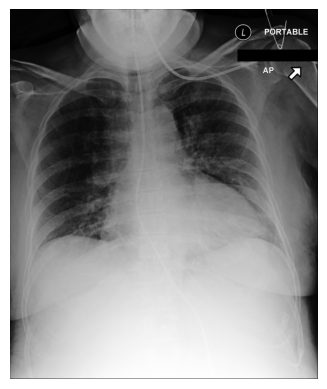

=== USER INSTRUCTION ===
Act as a board-certified radiologist specialized in adult chest radiography.
Base every statement only on the provided image(s). If information is missing, say so.
Use RSNA/ACR-style reporting sections and concise clinical language. Prioritize the IMPRESSION as a short, actionable summary.
Use standardized terms (RadLex/CheXpert lexicon) and always include location, laterality, extent, and acuity.
Handle uncertainty explicitly and never invent comparisons.
Comment on study quality/limitations and devices/lines/tubes.
Use EXACTLY these headers in order: Technique, View, Findings, Impression.


=== ASSISTANT REPORT ===
                                 FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ year old woman with increased DOE  // Eval for fluid overload 
 Eval for fluid overload
 
 IMPRESSION: 
 
 In comparison with the study of ___, the tip of the Dobhoff tube extends
 at least to the lower body of the stomach, were crosses the lower ma

In [ ]:
import random
import matplotlib.pyplot as plt

idx = random.randrange(len(train_ds))                           # pick a random index
# idx = 550000                           # pick a random index
sample = train_ds[idx]                                          # fetch (lazy-open image)

img = sample["messages"][0]["content"][1]["image"]        # PIL.Image
user_text = sample["messages"][0]["content"][0]["text"]   # instruction + (scrubbed) history
report_text = sample["messages"][1]["content"][0]["text"] # target report

plt.imshow(img); plt.axis("off");
plt.show()

print("=== USER INSTRUCTION ===")
print(user_text)
print("\n=== ASSISTANT REPORT ===")
print(report_text)


<a name="Train"></a>
## Train the model


In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from transformers import EarlyStoppingCallback
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)  # Enable for training!

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=train_ds,
    eval_dataset=val_ds,  # Add evaluation dataset
    compute_metrics=None,
    args=SFTConfig(
        num_train_epochs=1,  # 1 epoch or modify as needed

        per_device_train_batch_size=28,
        gradient_accumulation_steps=1,
        ignore_data_skip = True,

        warmup_ratio=0.03,
        learning_rate=1e-4,
        lr_scheduler_type="cosine",
        weight_decay=0.01,
        max_grad_norm=1.0,

        # Precision & speed
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        optim="adamw_torch_fused",
        logging_steps=10,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},

        # Evaluate
        eval_strategy="steps",
        eval_steps=1000,
        per_device_eval_batch_size=28,
        eval_accumulation_steps=4,
        prediction_loss_only=True,

        # Data loading speed-ups
        dataloader_num_workers=8,
        dataloader_prefetch_factor=1,
        dataloader_pin_memory=True,

        # Vision finetuning
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,

        # Save checkpoints
        save_strategy="steps",
        save_steps=1000,
        save_total_limit=3,
        save_safetensors=True,  # Save checkpoints as safetensors

        push_to_hub=True,
        hub_model_id="parsa-mhmdi/RadLLamaThinking_Stage1_Training_2",   # Replace with your repo path
        hub_private_repo=False,                        # Set this to False for a public repo
        hub_strategy="all_checkpoints",                     # "checkpoint" or "all_checkpoints"


        seed=3407,
        output_dir="/content/outputs",  # Make sure this matches the directory you're saving checkpoints
        report_to="wandb",  # For Weights and Biases
    ),
)



In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
9.771 GB of memory reserved.


In [ ]:
# # resume from a specific one you pushed
trainer_stats = trainer.train()

In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

### Save the Final model

In [ ]:
# Save model online
from google.colab import userdata

hf_token = userdata.get('HUGGINGFACE_API')
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
model.push_to_hub("parsa-mhmdi/RadLLamaThinking_Stage1_Final", token = hf_token) # Online saving
tokenizer.push_to_hub("parsa-mhmdi/RadLLamaThinking_Stage1_Final", token = hf_token) # Online saving
model.push_to_hub_merged("parsa-mhmdi/RadLLamaThinking_Stage1_Final", tokenizer, token = hf_token)

<a name="Inference"></a>
## Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
# --- Inference for your CombinedChestXRDataset sample ---
from unsloth import FastVisionModel
from transformers import TextStreamer

# 1) Put the model into inference mode (important for Unsloth vision models)
FastVisionModel.for_inference(model)
model.eval()

# 2) Pick a sample from one of your test splits
#    e.g., test_chex (CheXpert 5% test) or test_mim (MIMIC 5% test)
sample = test_chex[100]   # or: sample = test_mim[100]

# 3) Extract the PIL image and the user text from the dataset’s Unsloth-style messages
#    messages structure:
#    messages[0] == user turn -> content = [ {"type":"text","text":...}, {"type":"image","image": PIL.Image} ]
user_turn    = sample["messages"][0]
user_content = user_turn["content"]

# The dataset guarantees order: text first, then image — but we'll be safe:
image = None
instruction_text = None
for part in user_content:
    if part.get("type") == "image":
        image = part.get("image")           # PIL.Image (already resized by your dataset transform)
    elif part.get("type") == "text":
        instruction_text = part.get("text") # Full instruction text (CheXpert includes history here)

assert image is not None, "No image found in sample['messages'][0]['content']"
assert instruction_text is not None, "No text instruction found in sample['messages'][0]['content']"

# 4) Build the user message for generation.
#    Unsloth expects an image placeholder dict alongside the text.
gen_messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},                          # placeholder; actual pixels are passed to tokenizer below
            {"type": "text", "text": instruction_text}  # use the SAME instruction you trained with
        ]
    }
]

# 5) Turn the chat into a prompt string with a generation tag
input_text = tokenizer.apply_chat_template(
    gen_messages,
    add_generation_prompt=True
)

# 6) Tokenize both the image and the text together for the model
#    Note: keep add_special_tokens=False for Unsloth’s chat template
inputs = tokenizer(
    image,                 # PIL.Image -> vision tensors handled under the hood
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# 7) Stream the model’s decoded text to stdout as it generates
streamer = TextStreamer(tokenizer, skip_prompt=True)

# 8) Generate!
_ = model.generate(
    **inputs,
    streamer=streamer,
    max_new_tokens=256,     # a bit more room for full reports
    use_cache=True,
    temperature=0.7,        # lower temp for clinical-style outputs
    top_p=0.9,
)


                                 FINAL REPORT
 HISTORY:  Hypoxia.
 
 TECHNIQUE:  PA and lateral views of the chest.
 
 COMPARISON:  ___.
 
 FINDINGS:
 
 There is unchanged prominence of the azygos contour, and bilateral diffuse
 reticulonodular opacities which may be due to patient's history of emphysema. 
 No large pleural effusion is identified.  No pneumothorax is present.  The
 cardiac and mediastinal contours are stable, and aortic knob calcification is
 redemonstrated.  No acute osseous abnormality


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Panoramic radiograph of the jaw showing well-defined radiolucency (arrowheads) of the right side and unerupted second permanent maxillary molar (arrow).<|eot_id|>


## Merge weights and push to huggingface

In [ ]:
from huggingface_hub import snapshot_download

repo_id = "parsa-mhmdi/RadLLamaThinking_Stage1_Training_2"
local_checkpoint_dir = "./parsa-mhmdi/RadLLamaThinking_Stage1_Training_2"  # Or any local path you prefer

# Download only the specific checkpoint subfolder
snapshot_download(
    repo_id=repo_id,
    local_dir=local_checkpoint_dir,
    repo_type="model"  # Default, but explicit for clarity
)

Fetching 100 files:   0%|          | 0/100 [00:00<?, ?it/s]

checkpoint-1000/adapter_model.safetensor(…):   0%|          | 0.00/420M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/420M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

checkpoint-1000/optimizer.pt:   0%|          | 0.00/839M [00:00<?, ?B/s]

checkpoint-1000/rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

checkpoint-1000/scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

checkpoint-1000/tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

checkpoint-1000/training_args.bin:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

checkpoint-2000/adapter_model.safetensor(…):   0%|          | 0.00/420M [00:00<?, ?B/s]

checkpoint-2000/optimizer.pt:   0%|          | 0.00/839M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

checkpoint-2000/rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

checkpoint-2000/scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

checkpoint-2000/tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

checkpoint-2000/training_args.bin:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

checkpoint-3000/adapter_model.safetensor(…):   0%|          | 0.00/420M [00:00<?, ?B/s]

checkpoint-3000/optimizer.pt:   0%|          | 0.00/839M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

checkpoint-3000/rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

checkpoint-3000/scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

checkpoint-3000/tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

checkpoint-3000/training_args.bin:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

checkpoint-4000/adapter_model.safetensor(…):   0%|          | 0.00/420M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

checkpoint-4000/optimizer.pt:   0%|          | 0.00/839M [00:00<?, ?B/s]

checkpoint-4000/scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

checkpoint-4000/rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

checkpoint-4000/tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

checkpoint-4000/training_args.bin:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

checkpoint-5000/adapter_model.safetensor(…):   0%|          | 0.00/420M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

checkpoint-5000/optimizer.pt:   0%|          | 0.00/839M [00:00<?, ?B/s]

checkpoint-5000/rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

checkpoint-5000/scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

checkpoint-5000/tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

checkpoint-5000/training_args.bin:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

checkpoint-6000/adapter_model.safetensor(…):   0%|          | 0.00/420M [00:00<?, ?B/s]

checkpoint-6000/optimizer.pt:   0%|          | 0.00/839M [00:00<?, ?B/s]

checkpoint-6000/rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

checkpoint-6000/scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

checkpoint-6000/tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

checkpoint-6000/training_args.bin:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

checkpoint-7000/adapter_model.safetensor(…):   0%|          | 0.00/420M [00:00<?, ?B/s]

checkpoint-7000/optimizer.pt:   0%|          | 0.00/839M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

checkpoint-7000/rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

checkpoint-7000/scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

checkpoint-7000/tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

checkpoint-7000/training_args.bin:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

training_args.bin:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

'/content/parsa-mhmdi/RadLLamaThinking_Stage1_Training_2'

In [ ]:
from google.colab import userdata
from huggingface_hub import login
import os
from unsloth import FastVisionModel
import torch

hf_token = userdata.get("HUGGINGFACE_API")
login(token=hf_token)

BASE_MODEL_ID   = "unsloth/Llama-3.2-11B-Vision-Instruct"
LORA_REPO       = "parsa-mhmdi/RadLLamaThinking_Stage1_Training_2"
LORA_CHECKPOINT = "checkpoint-7000" # Specify the checkpoint folder

TARGET_REPO     = "parsa-mhmdi/RadLLamaThinking_Stage1_Final"

# 1. Load base model
model, tokenizer = FastVisionModel.from_pretrained(
    BASE_MODEL_ID,
    max_seq_length=2048,
    use_gradient_checkpointing="unsloth",
    # No need to specify load_in_4bit here, it will be handled when loading the PEFT model
)

# 2. Load LoRA adapter weights from the specific checkpoint
model, tokenizer = FastVisionModel.from_pretrained(
    model_name = os.path.join(LORA_REPO, LORA_CHECKPOINT), # Path to the specific checkpoint folder
    max_seq_length=2048,
    load_in_4bit=True, # Specify load_in_4bit here if you want to load the PEFT model in 4bit
    use_gradient_checkpointing="unsloth",
    # Make sure to pass the base model and tokenizer to from_pretrained when loading PEFT adapters
    # This is not explicitly shown in unsloth docs, but is common practice with PEFT
    # You might need to explicitly pass the base model and tokenizer depending on the unsloth version
)


# 3. Push adapter only (This is usually done from the trainer or manually after saving adapters)
# If you want to push the adapters, you should save them first
# model.save_pretrained("lora_adapters")
# tokenizer.save_pretrained("lora_adapters")
# model.push_to_hub(TARGET_REPO, token=hf_token)
# tokenizer.push_to_hub(TARGET_REPO, token=hf_token)

# 4. Push merged model (base ⊕ LoRA)
# This will merge the loaded PEFT adapters with the base model and push the full model
model.push_to_hub_merged(TARGET_REPO, tokenizer, token=hf_token)

print("✅ Merged full model uploaded to", TARGET_REPO)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.4: Fast Mllama patching. Transformers: 4.56.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

==((====))==  Unsloth 2025.9.4: Fast Mllama patching. Transformers: 4.56.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

DEBUG: Removed incorrectly saved weight file: model-00001-of-00002.safetensors
DEBUG: Removed incorrectly saved weight file: model-00002-of-00002.safetensors


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...hinking_Stage1_Final/tokenizer.json:   2%|1         |  295kB / 17.2MB            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00005.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...al/model-00001-of-00005.safetensors:   1%|1         | 50.2MB / 4.99GB            

Unsloth: Merging weights into 16bit:  20%|██        | 1/5 [01:44<06:59, 104.90s/it]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...al/model-00002-of-00005.safetensors:   0%|          | 4.28MB / 4.97GB            

Unsloth: Merging weights into 16bit:  40%|████      | 2/5 [03:54<05:58, 119.43s/it]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...al/model-00003-of-00005.safetensors:   0%|          | 4.28MB / 4.92GB            

Unsloth: Merging weights into 16bit:  60%|██████    | 3/5 [06:01<04:05, 122.74s/it]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...al/model-00004-of-00005.safetensors:   0%|          | 4.29MB / 5.00GB            

Unsloth: Merging weights into 16bit:  80%|████████  | 4/5 [08:21<02:09, 129.59s/it]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...al/model-00005-of-00005.safetensors:   3%|3         | 50.3MB / 1.47GB            

Unsloth: Merging weights into 16bit: 100%|██████████| 5/5 [09:00<00:00, 108.20s/it]


✅ Merged full model uploaded to parsa-mhmdi/RadLLamaThinking_Stage1_Final


In [ ]:
# 3. Push adapter only (This is usually done from the trainer or manually after saving adapters)
# If you want to push the adapters, you should save them first
model.save_pretrained("lora_adapters")
tokenizer.save_pretrained("lora_adapters")
model.push_to_hub(TARGET_REPO, token=hf_token)
tokenizer.push_to_hub(TARGET_REPO, token=hf_token)

# 4. Push merged model (base ⊕ LoRA)
# This will merge the loaded PEFT adapters with the base model and push the full model
# model.push_to_hub_merged(TARGET_REPO, tokenizer, token=hf_token)

print("✅ model stuff uploaded")

README.md:   0%|          | 0.00/638 [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...plpi65wng/adapter_model.safetensors:  12%|#1        | 50.3MB /  420MB            

Saved model to https://huggingface.co/parsa-mhmdi/RadLLamaThinking_Stage1_Final


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpebr_3hfd/tokenizer.json       : 100%|##########| 17.2MB / 17.2MB            

No files have been modified since last commit. Skipping to prevent empty commit.


✅ model stuff uploaded
